In [20]:
import os
import numpy as np
import pandas as pd

from rdflib import Graph

import tensorflow as tf
import ampligraph
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from ampligraph.evaluation import train_test_split_no_unseen, mr_score, mrr_score, hits_at_n_score

In [21]:
OWL_FILE = 'updated_ontology.owl'

print(f"ampligraph version: {ampligraph.__version__}")
print(f"TensorFlow version: {tf.__version__}")

if not os.path.exists(OWL_FILE):
    print(f"Файл {OWL_FILE} не найден! Убедитесь, что путь указан верно.")
    exit(0)

g = Graph()
g.parse(OWL_FILE, format='application/rdf+xml')
print("Онтология успешно загружена.")

triples = []
for s, p, o in g:
   if o.startswith("http"):
       triples.append((str(s), str(p), str(o)))

triples = np.array(triples)
print(f"Всего триплетов для обучения: {len(triples)}")

X_train, X_test = train_test_split_no_unseen(triples, test_size=200, allow_duplication=True)
print('Train set size:', X_train.shape)
print('Test set size:', X_test.shape)

model = ScoringBasedEmbeddingModel(
    k=100,
    eta=5,
    scoring_type='ComplEx',
    seed=42
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

model.compile(
    optimizer=optimizer,
    loss=loss,
    entity_relation_regularizer=regularizer
)

model.fit(
    X_train,
    batch_size=int(X_train.shape[0] / 10),
    epochs=50,
    verbose=True
)

ranks = model.evaluate(
    X_test,
    use_filter={'train': X_train, 'test': X_test},
    corrupt_side='s,o',
    verbose=True
)

flat_ranks = ranks.flatten()
valid_ranks = flat_ranks[flat_ranks > 0]

mr = mr_score(valid_ranks)
mrr = mrr_score(valid_ranks)
hits_1 = hits_at_n_score(valid_ranks, n=1)
hits_3 = hits_at_n_score(valid_ranks, n=3)
hits_10 = hits_at_n_score(valid_ranks, n=10)

print()
print("=== Evaluation Results ===")
print(f"MR  (Mean Rank):        {mr:.2f} (чем меньше, тем лучше)")
print(f"MRR (Mean Reciprocal Rank): {mrr:.3f} (чем ближе к 1, тем лучше)")
print(f"Hits@1:                {hits_1:.3f}")
print(f"Hits@3:                {hits_3:.3f}")
print(f"Hits@10:               {hits_10:.3f}")

entities = np.unique(np.concatenate([X_train[:, 0], X_train[:, 2], X_test[:, 0], X_test[:, 2]]))
entity_embeddings = model.get_embeddings(entities)

df_emb = pd.DataFrame(entity_embeddings, index=entities)
df_emb.columns = [f"dim_{i}" for i in range(1, df_emb.shape[1] + 1)]

df_emb.index = df_emb.index.str.replace(
    "http://www.semanticweb.org/admin/ontologies/2024/9/untitled-ontology-10#", "", regex=False
)

df_emb.to_csv("entity_embeddings.csv", header=False)
print("Эмбеддинги сущностей сохранены в entity_embeddings.csv")

print("Готово!")

ampligraph version: 2.0.0
TensorFlow version: 2.9.0
Онтология успешно загружена.
Всего триплетов для обучения: 24270
Train set size: (24070, 3)
Test set size: (200, 3)
Epoch 1/50
11/11 [==============================] - 4s 337ms/step - loss: 4312.7764
Epoch 2/50
11/11 [==============================] - 2s 163ms/step - loss: 4312.6953
Epoch 3/50
11/11 [==============================] - 2s 165ms/step - loss: 4312.6226
Epoch 4/50
11/11 [==============================] - 2s 160ms/step - loss: 4312.5542
Epoch 5/50
11/11 [==============================] - 2s 168ms/step - loss: 4312.4849
Epoch 6/50
11/11 [==============================] - 2s 161ms/step - loss: 4312.4150
Epoch 7/50
11/11 [==============================] - 2s 171ms/step - loss: 4312.3438
Epoch 8/50
11/11 [==============================] - 2s 181ms/step - loss: 4312.2695
Epoch 9/50
11/11 [==============================] - 2s 177ms/step - loss: 4312.1924
Epoch 10/50
11/11 [==============================] - 2s 186ms/step - loss: 4

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from sklearn.cluster import KMeans
%matplotlib inline

In [23]:
emb_df = pd.read_csv("entity_embeddings.csv", header=None, index_col=0)

emb_df.head()
 # Посмотрим первые 5 строк

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,,,,,,,,,,,,,,,,,,,,,
http://www.semanticweb.org/admin/ontologies/2024/9/untitled-ontology-10,0.059148,0.003570,-0.011380,-0.024741,0.025571,0.013848,-0.029176,-0.013715,-0.037623,-0.016393,...,-0.008496,-0.010220,0.016875,-0.042684,-0.038110,0.034359,-0.019831,-0.019550,-0.030517,0.022629
Category,0.022991,-0.072097,-0.006407,0.018958,-0.019109,0.008092,0.043280,0.043339,-0.049100,0.035983,...,0.007287,0.045528,-0.011711,-0.001003,0.007345,0.009042,0.074659,-0.030724,0.007206,-0.033514
Cuisine,0.012822,-0.056122,0.056847,0.038089,-0.068312,-0.031065,-0.013994,0.006120,-0.019615,0.066172,...,-0.028151,0.070998,-0.000951,-0.047902,-0.059960,-0.048269,0.065814,0.011453,0.058282,-0.022216
DietaryRestriction,-0.053515,-0.044489,-0.048583,0.010196,0.021410,-0.047814,0.062760,0.019828,-0.033421,0.051078,...,0.068521,-0.040783,-0.028604,-0.067508,-0.013319,0.038540,0.032841,-0.028090,0.043244,-0.025344
Ingredient,-0.093247,-0.102768,0.068417,0.042342,0.044050,0.116550,0.073775,-0.078531,0.100583,-0.099879,...,0.054190,0.104405,-0.056311,-0.061871,-0.010476,0.087600,0.048704,-0.066429,-0.072955,0.059250


Форма после PCA: (4408, 2)


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\adjustText\__init__.py:419: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.draw_without_rendering()


MemoryError: Unable to allocate 34.5 TiB for an array with shape (2525030, 7515326, 2) and data type bool

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


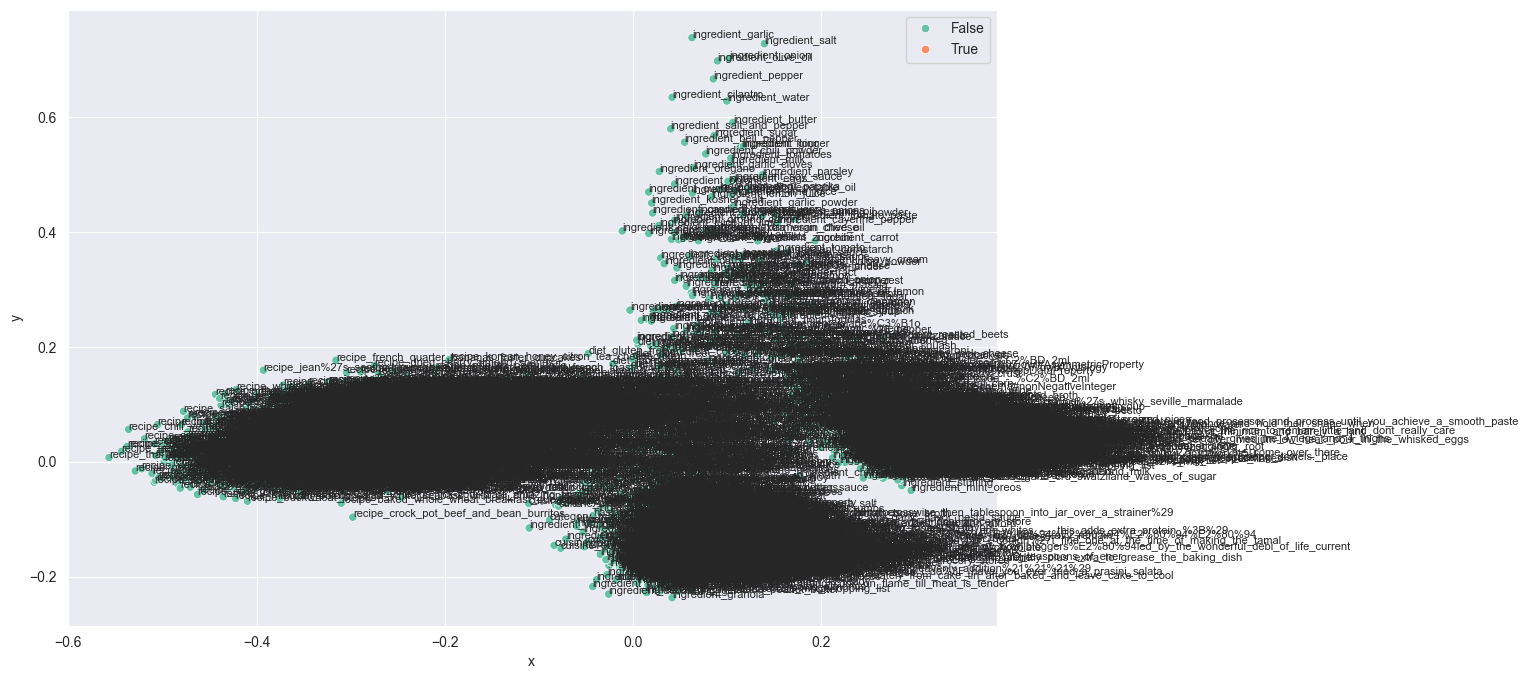

In [24]:
pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(emb_df.values)

viz_df = pd.DataFrame(emb_2d, 
                      columns=["x", "y"], 
                      index=emb_df.index)

print("Форма после PCA:", viz_df.shape)
viz_df.head()

k = 5  # например, хотим 5 кластеров
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(emb_df.values)
viz_df["cluster"] = kmeans.labels_

# Сохраняем результаты в viz_df
viz_df["cluster"] = kmeans.labels_

# 1. Визуализация после PCA (без кластеризации)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df, 
    x="x", 
    y="y", 
    hue=emb_df.index.str.contains("Category"),  # Пример: условное разделение категорий
    palette="Set2"
)

texts = []
for idx, row in viz_df.iterrows():
    texts.append(plt.text(row.x, row.y, str(idx), fontsize=8))

adjust_text(texts)
plt.title("Embeddings after PCA (by Category)")
plt.show()

# 2. Визуализация с кластерами K-Means
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df, 
    x="x", 
    y="y", 
    hue="cluster",  # цвет точек по номеру кластера
    palette="Set1"
)

texts = []
for idx, row in viz_df.iterrows():
    texts.append(plt.text(row.x, row.y, str(idx), fontsize=8))

adjust_text(texts)
plt.title("Embeddings Clusters (PCA)")
plt.show()

In [25]:
for c in range(k):
    cluster_items = viz_df[viz_df["cluster"] == c]
    print(f"\n=== Кластер {c} ===")
    cluster_items.head(10)
    print(f"Всего элементов в кластере: {len(cluster_items)}")


=== Кластер 0 ===
Всего элементов в кластере: 820

=== Кластер 1 ===
Всего элементов в кластере: 1429

=== Кластер 2 ===
Всего элементов в кластере: 1476

=== Кластер 3 ===
Всего элементов в кластере: 454

=== Кластер 4 ===
Всего элементов в кластере: 229


In [26]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

cost_class
1    0.443739
2    0.328040
0    0.228221
Name: proportion, dtype: float64
Accuracy: 0.38
              precision    recall  f1-score   support

           0       0.16      0.05      0.08       302
           1       0.44      0.62      0.51       587
           2       0.33      0.30      0.31       434

    accuracy                           0.38      1323
   macro avg       0.31      0.32      0.30      1323
weighted avg       0.34      0.38      0.35      1323



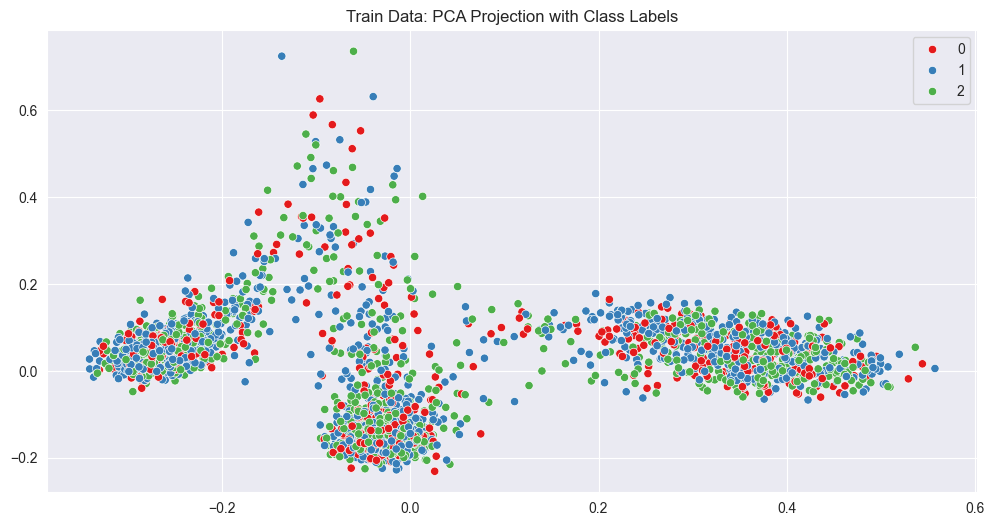

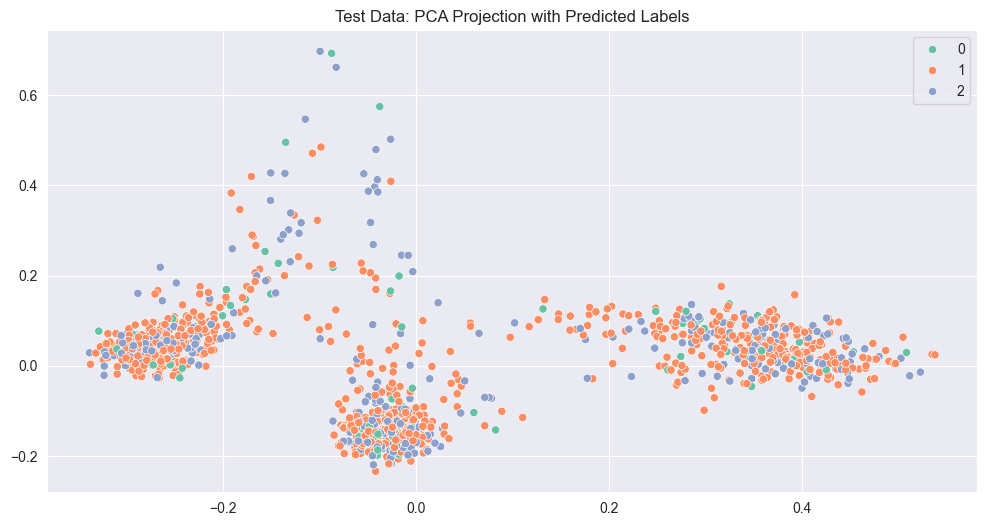

In [27]:
# Импортируем библиотеки для классификации

# Шаг 1. Создание целевой переменной для классификации
# Разделим данные на 3 класса на основе условного критерия (например, значения эмбеддингов)

df_emb['cost'] = np.random.uniform(1000, 10000, len(df_emb))  # Примерно симулируем значения
df_emb['cost_class'] = (
    (df_emb['cost'] < 3000).astype(int) +
    ((df_emb['cost'] >= 3000) & (df_emb['cost'] < 7000)).astype(int) * 2 +
    (df_emb['cost'] >= 7000).astype(int) * 3 - 1
)

# Проверим распределение классов
print(df_emb['cost_class'].value_counts(normalize=True))



# Шаг 2. Подготовка признаков и целевой переменной
# Выбираем эмбеддинги как признаки для классификации
X = df_emb.iloc[:, :-2].values  # Все эмбеддинги (кроме 'cost' и 'cost_class')
y = df_emb['cost_class'].values  # Целевая переменная

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



# Шаг 3. Обучение модели XGBoost
clf = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax", random_state=42)
clf.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = clf.predict(X_test)

# Оценка качества классификации
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))



# Шаг 4. Визуализация результатов классификации
# Снижение размерности для визуализации
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Визуализация обучающей выборки
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=X_train_2d[:, 0],
    y=X_train_2d[:, 1],
    hue=y_train,
    palette="Set1",
    legend="full"
)
plt.title("Train Data: PCA Projection with Class Labels")
plt.show()

# Визуализация тестовой выборки
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=X_test_2d[:, 0],
    y=X_test_2d[:, 1],
    hue=y_pred,
    palette="Set2",
    legend="full"
)
plt.title("Test Data: PCA Projection with Predicted Labels")
plt.show()